<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select your Dataset

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Shape Set
# 1 = cifar10 (You can also choose a class with the CIFAR10_CLASS variable)
# 2 = Celeb faces
# 3 = ImageNette (You must choose a category with the IMAGENETTE_CATEGORY variable)
DATASET_CHOICE = 2

# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
# 0 = airplane
# 1 = automobile
# 2 = bird
# 3 = cat
# 4 = deer										
# 5 = dog
# 6 = frog
# 7 = horse
# 8 = ship
# 9 = truck
CIFAR10_CLASS = 6

# If using imagenette specify the image category to train on here
# Choose one of the following: "dog", "paraglider", "golfball", "church", "fish"
IMAGENETTE_CATEGORY = "paraglider"

# Choose Whether to Train or Load a Model

In [0]:
# True = Load and output results for a model trained on the chosen dataset
# False = Train on the chosen dataset and output results 
LOAD_MODEL = True

# Provide the filename of the model to load/save
# Leave as None to use the default filename which will be named after the dataset
MODEL_NAME = None

# If LOAD_MODEL = False, choose whether to save the model
# True = Train and save
# False = Train only
SAVE_MODEL = True

# Define Training Hyper-Parameters

In [0]:
BATCH_SIZE = 512
LEARNING_RATE = 0.001
TRAINING_EPOCHS = 10

# Library Imports

In [0]:
# TODO: Test which of these imports are needed

from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import models, backend, utils, optimizers, regularizers
from tensorflow.keras.layers import Input, Conv2D, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io
from skimage.transform import resize
from google.colab import drive, files

# Dataset Setup

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
HEAD is now at ceebb06 Update timelog.md
Removing output/
From https://github.com/conwayjw97/Image-Colourisation-with-Deep-Learning
 * branch            master     -> FETCH_HEAD
Already up to date.


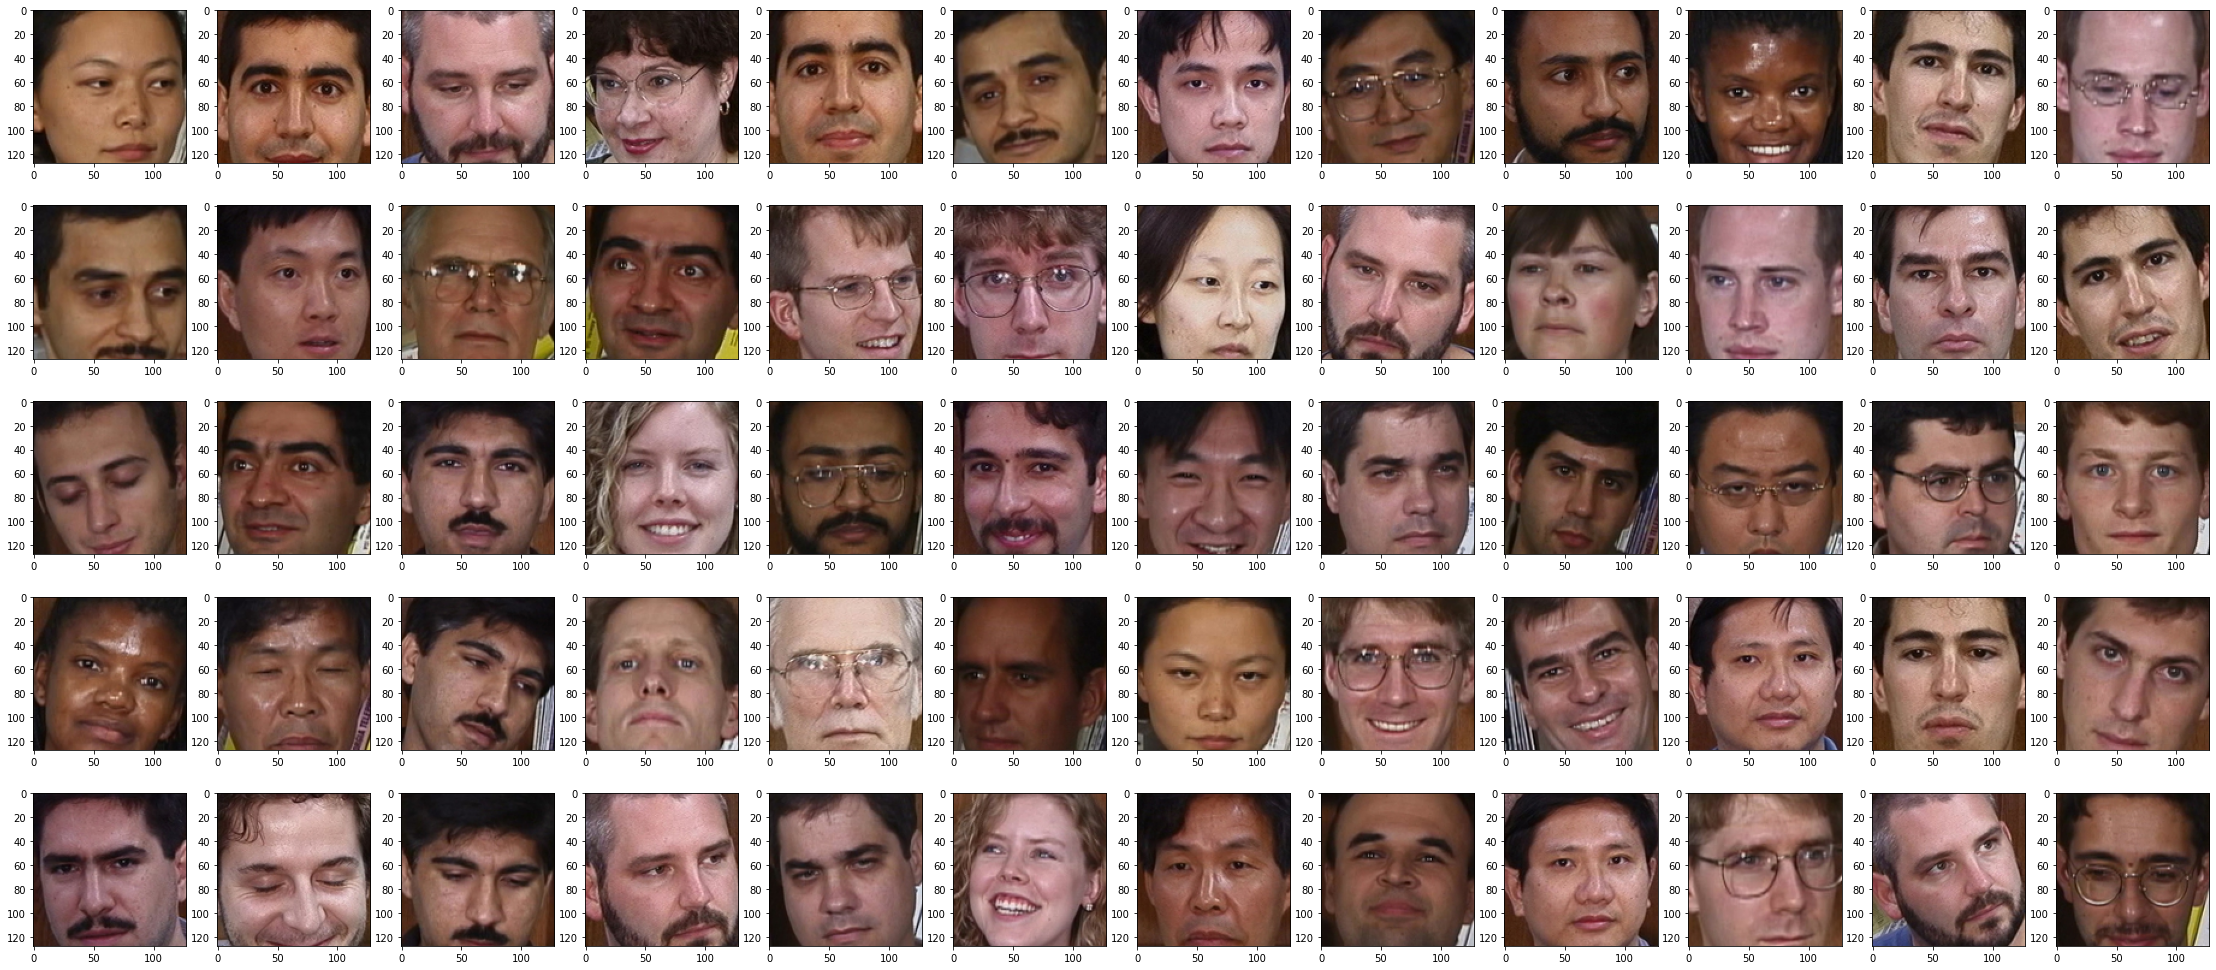

In [0]:
# Initialise empty repository to pull data into
!git init 
# Add the remote origin
!git remote add origin -f https://github.com/conwayjw97/Image-Colourisation-with-Deep-Learning.git
# Reset the HEAD in case a different folder was already pulled
!git reset --hard HEAD
!git clean -f -d
# Tell git we are checking out specific folders
!git config core.sparsecheckout true

# Shape Set
if(DATASET_CHOICE == 0):
  # Recursively checkout the dataset and models folders
  !echo "data/datasets/ShapeSet/*" >> .git/info/sparse-checkout
  !echo "data/models/cnn/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  # Load and shuffle
  images = []
  for image in io.imread_collection("data/datasets/ShapeSet/*.jpg"): 
    if(image.shape == (128, 128, 3)):
      images.append(np.array(image))
  indices = np.arange(len(images))
  np.random.shuffle(indices)
  images = np.array(images)[indices]
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  # Scale pixel data to [0,1]
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # Image output variables, change these to see different images on the results
  output_count = 9
  index_offset = 0

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  for i in range(output_count):
    ax = fig.add_subplot(1,output_count,i+1)
    plt.imshow(images[i])

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = (train_images[:,:,:,0] + train_images[:,:,:,1] + train_images[:,:,:,2]) / 3
  train_y = tf.expand_dims(train_y[:,:,:], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = (test_images[:,:,:,0] + test_images[:,:,:,1] + test_images[:,:,:,2]) / 3
  test_y = tf.expand_dims(test_y[:,:,:], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "ShapeSet"

  # Adjust batch size if it's too big for the dataset
  if(BATCH_SIZE > 8):
    BATCH_SIZE = 8 

# Cifar10
elif(DATASET_CHOICE == 1):
  # Recursively checkout the models folders
  !echo "data/models/cnn/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  # Load and scale dataset
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  # Prune dataset to chosen class
  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    train_labels = train_labels[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]
    test_labels = test_labels[class_test_indices[:,0]]
  
  # Output portion of the dataset
  image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      if(CIFAR10_CLASS is None):
        plt.title(image_labels[int(train_labels[count])])
      plt.imshow(train_images[count])
      count += 1

  # Image output variables, change these to see different images on the results
  output_count = 12
  index_offset = 20

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    if(CIFAR10_CLASS is not None):
      MODEL_NAME = "Cifar10-" + str(CIFAR10_CLASS)
    else:
      MODEL_NAME = "Cifar10"

# Faces Images
elif(DATASET_CHOICE == 2):
  # Recursively checkout the dataset and models folders
  !echo "data/datasets/face_images/*" >> .git/info/sparse-checkout
  !echo "data/models/cnn/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  images = train_images = test_images = []
  for image in io.imread_collection("data/datasets/face_images/*.jpg"): 
    images.append(resize(image, (128, 128)))
  train_images = np.array(images)[0:-1:2,:,:,:]
  test_images = np.array(images)[1::2,:,:,:]

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      plt.imshow(train_images[30+count])
      count += 1

  # Image output variables, change these to see different images on the results
  index_offset = 20
  output_count = 12

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "Faces"

  # Adjust batch size if it's too big for the dataset
  if(BATCH_SIZE > 128):
    BATCH_SIZE = 128

# Imagenette
elif(DATASET_CHOICE == 3):
  # Recursively checkout the dataset and models folders
  !echo "data/datasets/imagenette2-160/*" >> .git/info/sparse-checkout
  !echo "data/models/cnn/*" >> .git/info/sparse-checkout
  # Pull dataset from repository
  !git pull origin master

  # Load and resize dataset
  categories = {"dog":"n02102040", "paraglider":"n03888257", "golfball":"n03445777", "church":"n03028079", "fish":"n01440764"}
  print("Loading and resizing training and testing images, this may take a few minutes.")
  images = []
  for image in io.imread_collection("data/datasets/imagenette2-160/train/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images)
  images = []
  for image in io.imread_collection("data/datasets/imagenette2-160/val/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  test_images = np.array(images)

  # Output portion of the dataset
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)  
      plt.imshow(train_images[30+count])
      count += 1

  # Image output variables, change these to see different images on the results
  index_offset = 0
  output_count = 12

  # Convert to YUV
  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]
  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

  # Give default model name if needed
  if(MODEL_NAME is None):
    MODEL_NAME = "Imagenette-" + categories[IMAGENETTE_CATEGORY]

# DCNN Definition


In [0]:
# Input layer
y_input = Input(shape=(train_y.shape[1], train_y.shape[2], 1))

# Hidden layers
layer = Conv2D(8, (3, 3), activation='relu')(y_input)
layer = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = Dropout(0.2)(layer)
layer = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = Dropout(0.2)(layer)
layer = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
layer = Dropout(0.2)(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
layer = Dropout(0.2)(layer)
layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
layer = UpSampling2D((2, 2))(layer)

# Output layer
uv_out = Conv2D(2, (3, 3), activation='tanh', padding='same')(layer)

# Compile model
dcnn = Model(y_input, uv_out, name='dcnn')
opt = optimizers.Adam(lr=LEARNING_RATE)
dcnn.compile(optimizer=opt, loss='mse')
dcnn.summary()

total_loss = []
total_val_loss = []

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 126, 126, 8)       80        
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 63, 63, 32)        2336      
_________________________________________________________________
dropout_20 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout_21 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 128)       73856  


# CNN Training/Loading

In [0]:
load_dir = "data/models/cnn/"
save_dir = "output/models/"

# TODO: DOUBLE CHECK WHAT THESE MODEL DIRECTORIES WILL BE WHEN SOMEONE ELSE RUNS THE NOTEBOOK

# Load model
if(LOAD_MODEL):
  # Load model structure
  json_file = open(load_dir + MODEL_NAME + ".json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  dcnn = models.model_from_json(loaded_model_json)

  # Load model weights
  dcnn.load_weights(load_dir + MODEL_NAME + ".h5", by_name=False)

  # Compile model (in case you wish to train it again)
  dcnn.compile(optimizer=opt, loss='mse')

  # Load loss history
  total_loss = np.loadtxt(load_dir + MODEL_NAME + "-loss.csv", delimiter=',')
  total_val_loss = np.loadtxt(load_dir + MODEL_NAME + "-val_loss.csv", delimiter=',')

  print("Loaded model from disk")

# Train model
else:
  # Data generator for data augmentation
  datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=60)
  train_iterator = datagen.flow(train_y, train_uv, batch_size=BATCH_SIZE)

  # Train model
  start = time.time()
  history = dcnn.fit(train_iterator, steps_per_epoch=int(train_yuv.shape[0]/BATCH_SIZE), epochs=TRAINING_EPOCHS, validation_data=(test_y, test_uv), validation_steps=int(test_yuv.shape[0]/BATCH_SIZE), verbose=1)
  print("Total time taken: %ds" % (time.time()-start))

  # Get loss history
  total_loss += history.history["loss"]
  total_val_loss += history.history["val_loss"]

  if(SAVE_MODEL):
    !mkdir -p output/models/
    
    # Save model structure
    model_json = dcnn.to_json()
    with open(save_dir + MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)

    # Save model weights
    dcnn.save_weights(save_dir + MODEL_NAME + ".h5")

    # Save loss history
    np.savetxt(save_dir + MODEL_NAME + "-loss.csv", total_loss, delimiter=',')
    np.savetxt(save_dir + MODEL_NAME + "-val_loss.csv", total_val_loss, delimiter=',')

    print("Saved model to disk")

Loaded model from disk


# Diagnostic Learning Curves

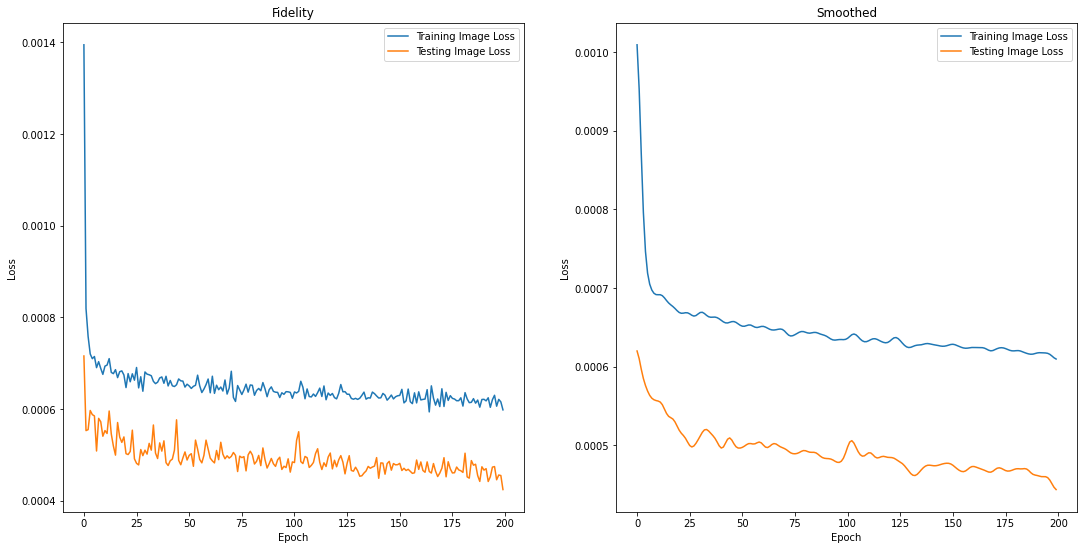

In [0]:
fig = plt.figure(figsize=(38, 9))

# Graph training and validation loss
ax = fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(total_loss, label="Training Image Loss")
plt.plot(total_val_loss, label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Graph training and validation loss after smoothing with a gaussian filter
ax = fig.add_subplot(1,4,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(total_loss, sigma=2), label="Training Image Loss")
plt.plot(gaussian_filter1d(total_val_loss, sigma=2), label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

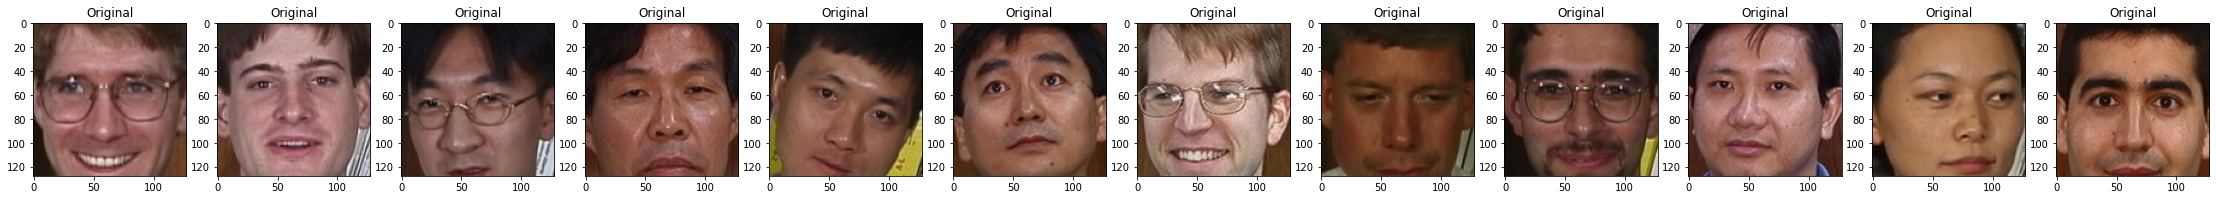

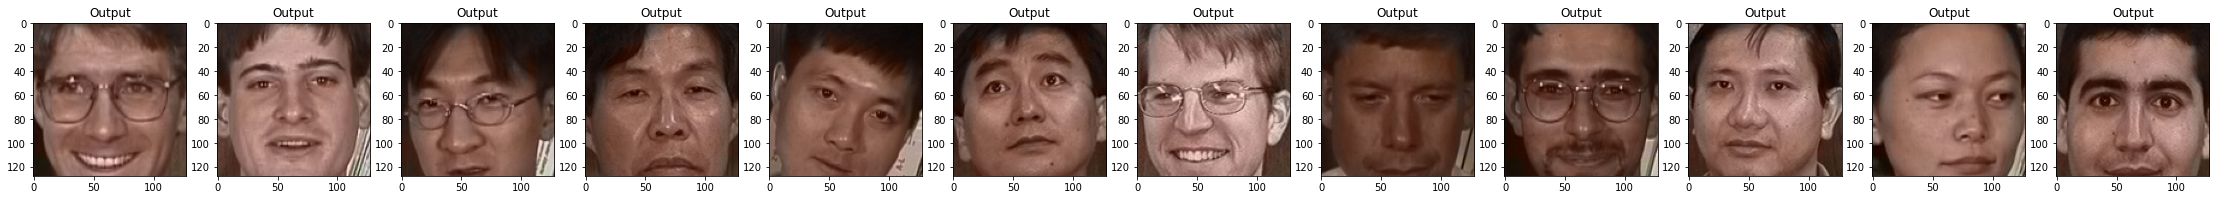

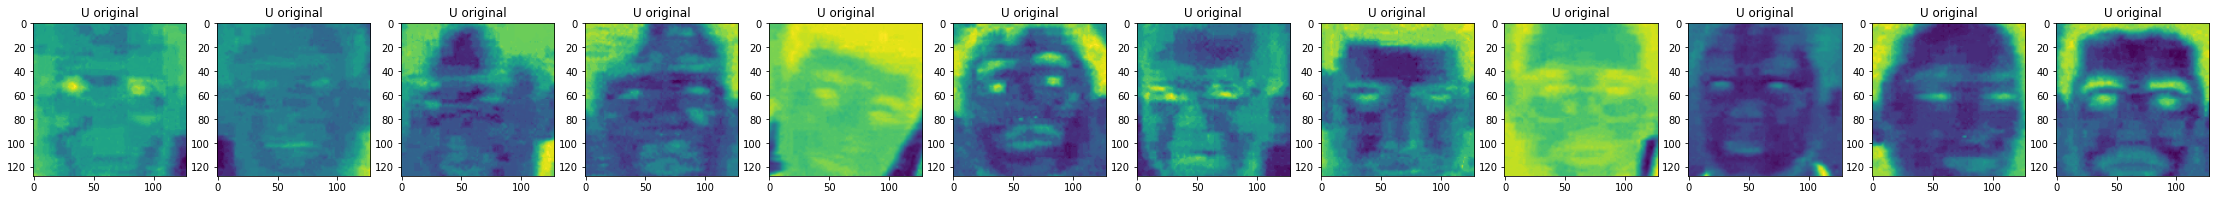

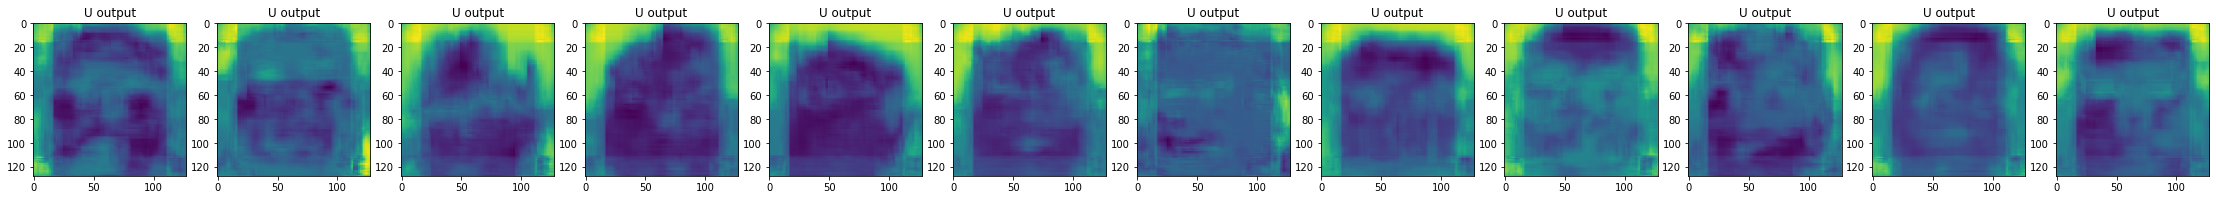

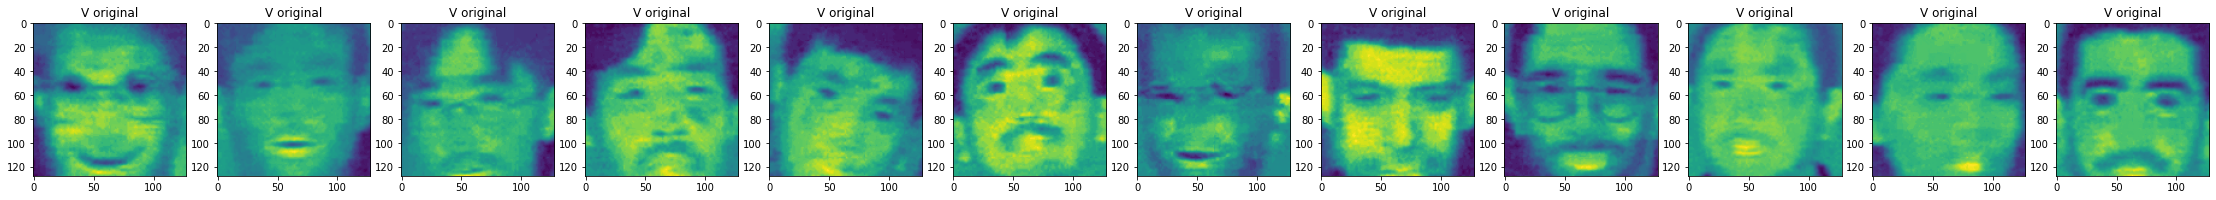

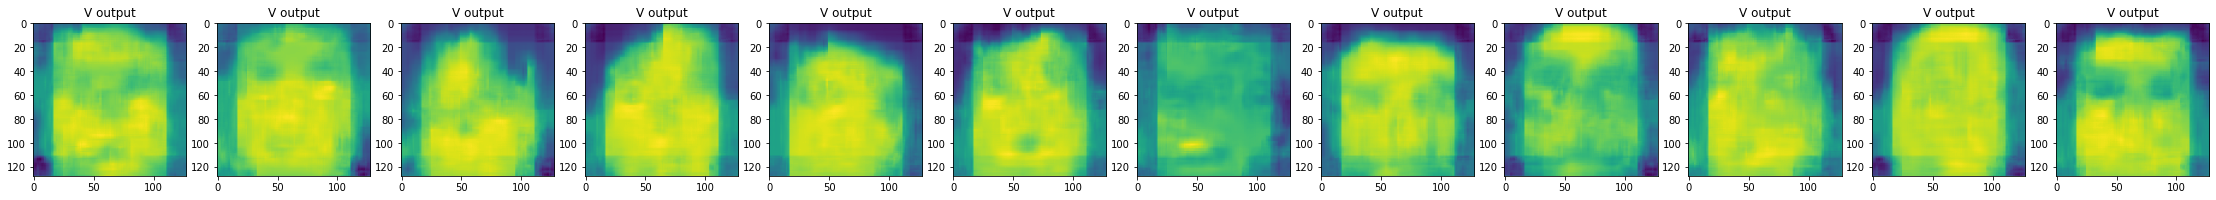

In [0]:
# Get output for training image Y channel
output = dcnn.predict(train_y)
result = np.zeros((train_y.shape[0], train_y.shape[1], train_y.shape[2], 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

# Graph results
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

# Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

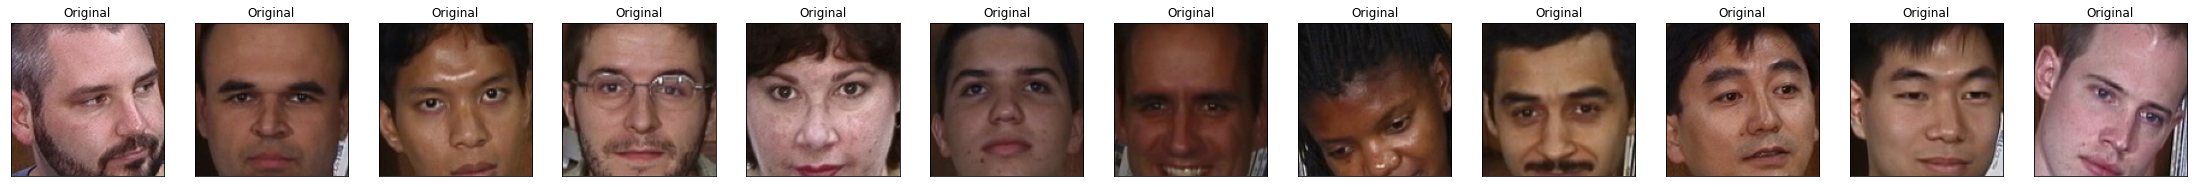

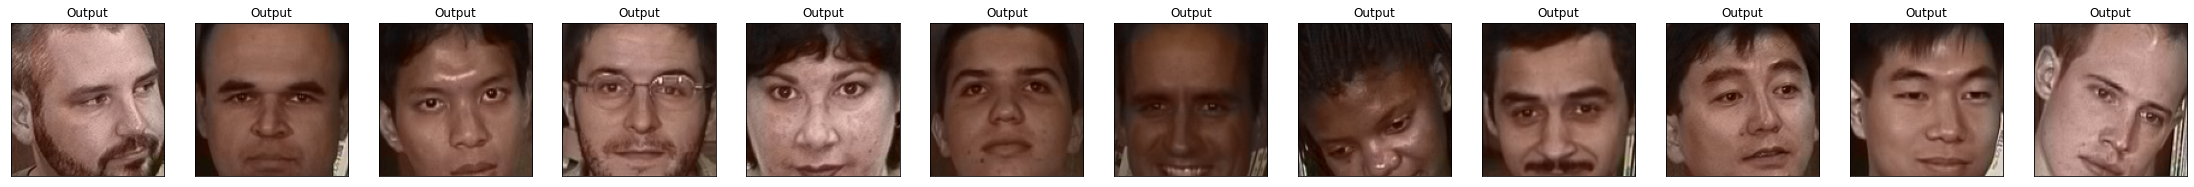

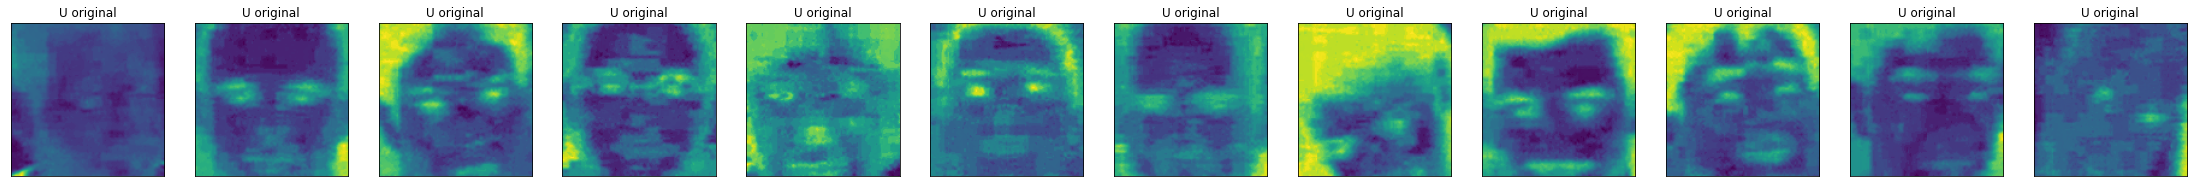

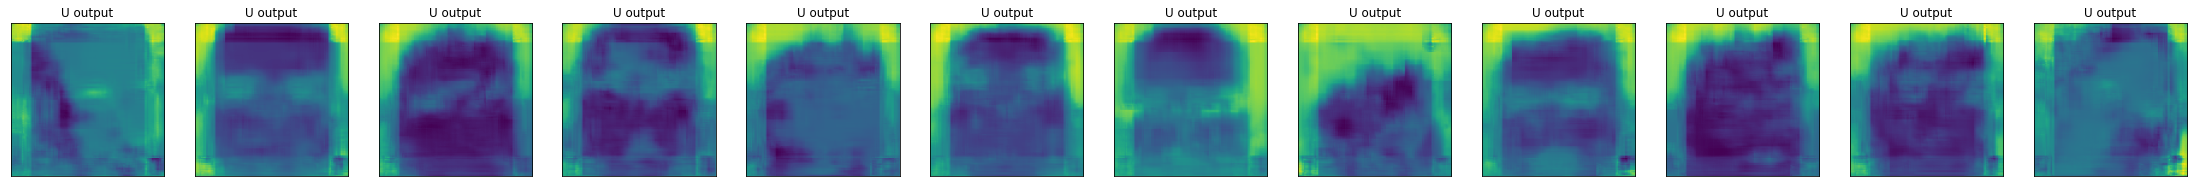

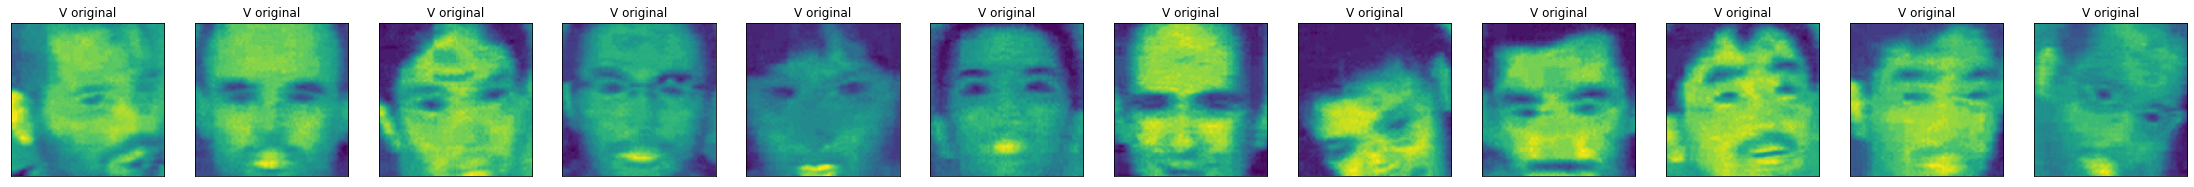

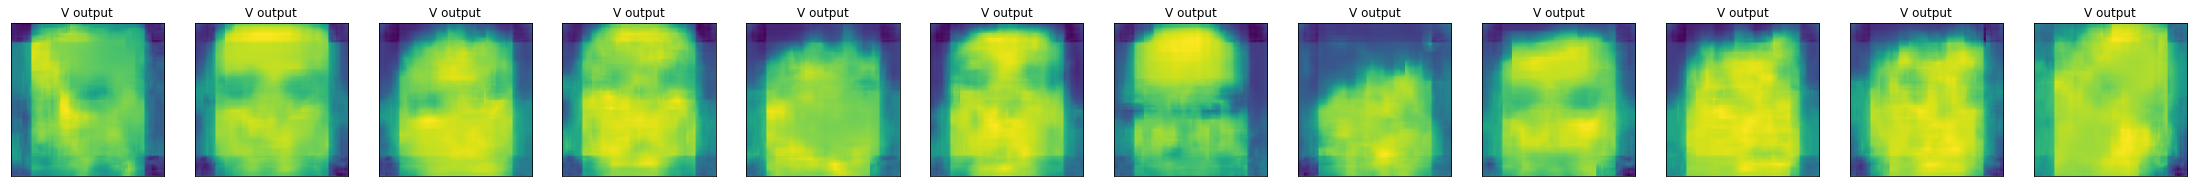

In [0]:
# Get output for testing image Y channel
output = dcnn.predict(test_y)
result = np.zeros((test_yuv.shape[0], train_y.shape[1], train_y.shape[2], 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
index_offset = 20
# Graph results
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  ax = fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("Original")
  plt.imshow(test_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("U original")
  plt.imshow(test_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("V original")
  plt.imshow(test_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])